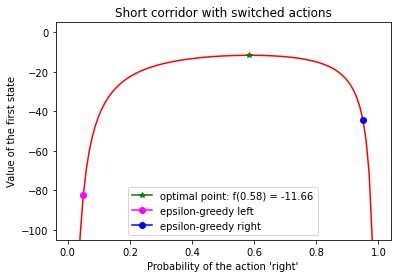

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.69s/it]


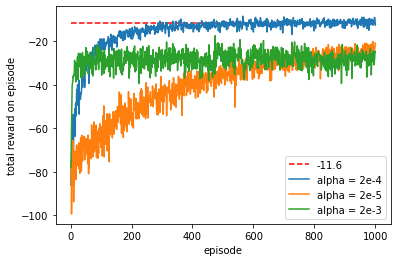

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


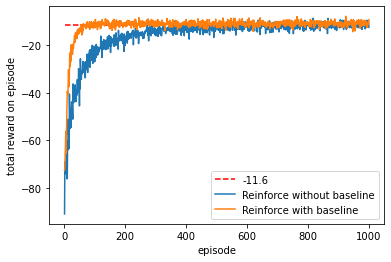

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

def true_value(p):
    """ True value of the first state
    Args:
        p (float): probability of the action 'right'.
    Returns:
        True value of the first state.
        The expression is obtained by manually solving the easy linear system
        of Bellman equations using known dynamics.
    """
    return (2 * p - 4) / (p * (1 - p))

class ShortCorridor:
    """
    Short corridor environment, see Example 13.1
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.state = 0

    def step(self, go_right):
        """
        Args:
            go_right (bool): chosen action
        Returns:
            tuple of (reward, episode terminated?)
        """
        if self.state == 0 or self.state == 2:
            if go_right:
                self.state += 1
            else:
                self.state = max(0, self.state - 1)
        else:
            if go_right:
                self.state -= 1
            else:
                self.state += 1

        if self.state == 3:
            # terminal state
            return 0, True
        else:
            return -1, False

def softmax(x):
    t = np.exp(x - np.max(x))
    return t / np.sum(t)

class ReinforceAgent:
    """
    ReinforceAgent that follows algorithm
    'REINFORNCE Monte-Carlo Policy-Gradient Control (episodic)'
    """
    def __init__(self, alpha, gamma):
        # set values such that initial conditions correspond to left-epsilon greedy
        self.theta = np.array([-1.47, 1.47])
        self.alpha = alpha
        self.gamma = gamma
        # first column - left, second - right
        self.x = np.array([[0, 1],
                           [1, 0]])
        self.rewards = []
        self.actions = []

    def get_pi(self):
        h = np.dot(self.theta, self.x)
        t = np.exp(h - np.max(h))
        pmf = t / np.sum(t)
        # never become deterministic,
        # guarantees episode finish
        imin = np.argmin(pmf)
        epsilon = 0.05

        if pmf[imin] < epsilon:
            pmf[:] = 1 - epsilon
            pmf[imin] = epsilon

        return pmf

    def get_p_right(self):
        return self.get_pi()[1]

    def choose_action(self, reward):
        if reward is not None:
            self.rewards.append(reward)

        pmf = self.get_pi()
        go_right = np.random.uniform() <= pmf[1]
        self.actions.append(go_right)

        return go_right

    def episode_end(self, last_reward):
        self.rewards.append(last_reward)

        # learn theta
        G = np.zeros(len(self.rewards))
        G[-1] = self.rewards[-1]

        for i in range(2, len(G) + 1):
            G[-i] = self.gamma * G[-i + 1] + self.rewards[-i]

        gamma_pow = 1

        for i in range(len(G)):
            j = 1 if self.actions[i] else 0
            pmf = self.get_pi()
            grad_ln_pi = self.x[:, j] - np.dot(self.x, pmf)
            update = self.alpha * gamma_pow * G[i] * grad_ln_pi

            self.theta += update
            gamma_pow *= self.gamma

        self.rewards = []
        self.actions = []

class ReinforceBaselineAgent(ReinforceAgent):
    def __init__(self, alpha, gamma, alpha_w):
        super(ReinforceBaselineAgent, self).__init__(alpha, gamma)
        self.alpha_w = alpha_w
        self.w = 0

    def episode_end(self, last_reward):
        self.rewards.append(last_reward)

        # learn theta
        G = np.zeros(len(self.rewards))
        G[-1] = self.rewards[-1]

        for i in range(2, len(G) + 1):
            G[-i] = self.gamma * G[-i + 1] + self.rewards[-i]

        gamma_pow = 1

        for i in range(len(G)):
            self.w += self.alpha_w * gamma_pow * (G[i] - self.w)

            j = 1 if self.actions[i] else 0
            pmf = self.get_pi()
            grad_ln_pi = self.x[:, j] - np.dot(self.x, pmf)
            update = self.alpha * gamma_pow * (G[i] - self.w) * grad_ln_pi

            self.theta += update
            gamma_pow *= self.gamma

        self.rewards = []
        self.actions = []

def trial(num_episodes, agent_generator):
    env = ShortCorridor()
    agent = agent_generator()

    rewards = np.zeros(num_episodes)
    for episode_idx in range(num_episodes):
        rewards_sum = 0
        reward = None
        env.reset()

        while True:
            go_right = agent.choose_action(reward)
            reward, episode_end = env.step(go_right)
            rewards_sum += reward

            if episode_end:
                agent.episode_end(reward)
                break

        rewards[episode_idx] = rewards_sum

    return rewards

def example_13_1():
    epsilon = 0.05
    fig, ax = plt.subplots(1, 1)

    # Plot a graph
    p = np.linspace(0.01, 0.99, 100)
    y = true_value(p)
    ax.plot(p, y, color='red')

    # Find a maximum point, can also be done analytically by taking a derivative
    imax = np.argmax(y)
    pmax = p[imax]
    ymax = y[imax]
    ax.plot(pmax, ymax, color='green', marker="*", label="optimal point: f({0:.2f}) = {1:.2f}".format(pmax, ymax))

    # Plot points of two epsilon-greedy policies
    ax.plot(epsilon, true_value(epsilon), color='magenta', marker="o", label="epsilon-greedy left")
    ax.plot(1 - epsilon, true_value(1 - epsilon), color='blue', marker="o", label="epsilon-greedy right")

    ax.set_ylabel("Value of the first state")
    ax.set_xlabel("Probability of the action 'right'")
    ax.set_title("Short corridor with switched actions")
    ax.set_ylim(ymin=-105.0, ymax=5)
    ax.legend()

    plt.show()
    plt.close()

def figure_13_1():
    num_trials = 100
    num_episodes = 1000
    gamma = 1
    agent_generators = [lambda : ReinforceAgent(alpha=2e-4, gamma=gamma),
                        lambda : ReinforceAgent(alpha=2e-5, gamma=gamma),
                        lambda : ReinforceAgent(alpha=2e-3, gamma=gamma)]
    labels = ['alpha = 2e-4',
              'alpha = 2e-5',
              'alpha = 2e-3']

    rewards = np.zeros((len(agent_generators), num_trials, num_episodes))

    for agent_index, agent_generator in enumerate(agent_generators):
        for i in tqdm(range(num_trials)):
            reward = trial(num_episodes, agent_generator)
            rewards[agent_index, i, :] = reward

    plt.plot(np.arange(num_episodes) + 1, -11.6 * np.ones(num_episodes), ls='dashed', color='red', label='-11.6')
    for i, label in enumerate(labels):
        plt.plot(np.arange(num_episodes) + 1, rewards[i].mean(axis=0), label=label)
    plt.ylabel('total reward on episode')
    plt.xlabel('episode')
    plt.legend(loc='lower right')

    plt.show()
    plt.close()

def figure_13_2():
    num_trials = 100
    num_episodes = 1000
    alpha = 2e-4
    gamma = 1
    agent_generators = [lambda : ReinforceAgent(alpha=alpha, gamma=gamma),
                        lambda : ReinforceBaselineAgent(alpha=alpha*10, gamma=gamma, alpha_w=alpha*100)]
    labels = ['Reinforce without baseline',
              'Reinforce with baseline']

    rewards = np.zeros((len(agent_generators), num_trials, num_episodes))

    for agent_index, agent_generator in enumerate(agent_generators):
        for i in tqdm(range(num_trials)):
            reward = trial(num_episodes, agent_generator)
            rewards[agent_index, i, :] = reward

    plt.plot(np.arange(num_episodes) + 1, -11.6 * np.ones(num_episodes), ls='dashed', color='red', label='-11.6')
    for i, label in enumerate(labels):
        plt.plot(np.arange(num_episodes) + 1, rewards[i].mean(axis=0), label=label)
    plt.ylabel('total reward on episode')
    plt.xlabel('episode')
    plt.legend(loc='lower right')

    plt.show()
    plt.close()

if __name__ == '__main__':
    example_13_1()
    figure_13_1()
    figure_13_2()